# Predicting physical activity based on weather ☀️

## Introduction 👋

### Context
The rain volume was earlier discovered as a reliable variable for predicting the demand on bicycle sharing networks (Pazdan, 2021) and commuting behaviour (Thomas et al, 2013)

As a cycling activist, I am constantly confronted with the argument that cycling is only an activity for good weather days. I would then respond with counter-arguments like "it just comes down to the right clothing" or "what about taking a thermo flask of tea with you for the ride, have a break while watching cows and windmills in the beautiful natural landscape" - Or look at the Dutch who ride their bikes every day in a country where it rains a lot. 

At this point, however, I  was wondering: How honest am I with myself here and how much I really ride on rainy days - or whether I am selling a story that I'm not living after. Because being authentic, in my opinion is a key ingredient as an activist. 


### Research Question
The given context made me wondering: 

>To which extent could I predict my personal activity based on the whether forecast? Am I predictable?

### Relevance
On the one hand, it would be exciting to know whether I possibly don't cycle that much in bad weather and simply pretend that it doesn't bother me.
In the next step, I would also find it exciting to create a kind of "Recommender System for Life" that takes into account all general conditions and, based on this, suggests activities for the day or deliberately schedules them in the calendar: For example, productivity slots, cooking, housework when the weather is bad for a long time, as well as social activities and sports based on the circumstances.

## Data: Import & Cleaning ✨


The data was collected over the period of the last year. On the one hand from my side through sources like Mi Fit, Strava, Apple Health (Bundled exported from Apple Health).

Originally I planned to use an export from the Dutch app "IkFiets", in which I had logged even more rides as it ran fully in the background and unlike Strava does not require user interaction before it starts tracking. Here, however, I am still waiting for the requested data export. 


### Data sources
- Apple Health
    - Strava
    - Mi Fit
    - iPhone

- KNMI - Koninklijk Nederlands Meteorologisch Instituut / Royal Dutch Meteorological Institute

### Considered period
2020 - Feb 2022 


### Variables: 

#### Independent variables (Causal)
- Weather
    - Precipitation (DR, RHX, RH)
    - Temperature (TN, TX)
    - Sun hours (SQ)
#### Dependent variables (Effectual)
- Kilometres




### Pre-processing 🛢

In [217]:
testvar = 1

In [218]:
# Allow output of multiple queries at once
from IPython.display import SVG, display

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import seaborn as sns

import re



# Apple Health data comes in XML format
import xmltodict
import json
import calendar 

# For merging multiple dfs
from functools import reduce


### Import: Apple Health

The Apple health data was exported easier than expected: Opened the app -> Share -> Got a Zip file full of files. 
Handling the data has been a new experience, since it came stored in XML  

In [219]:
apple_health = 'export.xml'
with open(apple_health, 'r') as xml_file:
    data = xmltodict.parse(xml_file.read())

records_list = data['HealthData']['Record']
df_ah = pd.DataFrame(records_list)
df_ah.head()

@type @sourceName @sourceVersion      @unit  \
0  HKQuantityTypeIdentifierHeartRate      Mi Fit   202108031059  count/min   
1  HKQuantityTypeIdentifierHeartRate      Mi Fit   202108031059  count/min   
2  HKQuantityTypeIdentifierHeartRate      Mi Fit   202108031059  count/min   
3  HKQuantityTypeIdentifierHeartRate      Mi Fit   202108031059  count/min   
4  HKQuantityTypeIdentifierHeartRate      Mi Fit   202108031059  count/min   

               @creationDate                 @startDate  \
0  2021-08-04 18:52:36 +0100  2021-08-04 18:44:00 +0100   
1  2021-08-04 19:02:05 +0100  2021-08-04 18:57:00 +0100   
2  2021-08-04 19:02:05 +0100  2021-08-04 18:58:00 +0100   
3  2021-08-04 19:02:05 +0100  2021-08-04 18:59:00 +0100   
4  2021-08-04 19:23:00 +0100  2021-08-04 19:02:00 +0100   

                    @endDate @value @device MetadataEntry  
0  2021-08-04 18:44:59 +0100     74     NaN           NaN  
1  2021-08-04 18:57:59 +0100    126     NaN           NaN  
2  2021-08-04 18:58:59 +0100     74     NaN           NaN  
3  2021-08-04 18:59:59 +0100     76     NaN           NaN  
4  2021-08-04 19:02:59 +0100     63     NaN           NaN

### Import: Google Location History

Thought about using Google Location History as well - yet this is less trivial than using the Apple Health source which bundles multible activity sources.

In [220]:

# google_loc = 'Records.json'
# with open(google_loc, 'r') as fh:
#     data = json.loads(fh.read())
# data = data['locations']



# for items in data['timelineObjects']:
#         try:
#             item = items['activitySegment']
#             start_coord = (int(item['startLocation']['latitudeE7'])/1e7, int(item['startLocation']['longitudeE7'])/1e7)
#             end_coord = (int(item['endLocation']['latitudeE7'])/1e7, int(item['endLocation']['longitudeE7'])/1e7)
#             distance = vincenty(start_coord, end_coord, miles=True)
#             dist_month = {"Month": month, "Distance":distance}


### Import: NL Weather provider





On my journey of finding appropriate weather APIs I came to realise that the best source of information would probably the official weather station of the country I've spent most time in during 2021: The Netherlands. 

The Royal Netherlands Meteorological Institute (KNMI) provides historical data and many interesting variables

I selected the data of 4 stations in order to receive the weather for the areas I was most active in during 2021 (Den Haag (Voorschoten, Hoek van Holland, Rotterdam) & Utrecht (De Bilt))

In [221]:
# SOURCE: ROYAL NETHERLANDS METEOROLOGICAL INSTITUTE (KNMI)
# Comment: These time series are inhomogeneous because of station relocations and changes in observation techniques. As a result these series are not suitable for trend analysis. For climate change studies we refer to the homogenized series of daily data <http://www.knmi.nl/nederland-nu/klimatologie/daggegevens> or the Central Netherlands Temperature <http://www.knmi.nl/kennis-en-datacentrum/achtergrond/centraal-nederland-temperatuur-cnt>.
# 
# STN         LON(east)   LAT(north)  ALT(m)      NAME
# 215         4.437       52.141      -1.10       Voorschoten 
# 260         5.180       52.100      1.90        De Bilt     
# 330         4.122       51.992      11.90       Hoek van Holland
# 344         4.447       51.962      -4.30       Rotterdam   
# FHVEC     : Vectorgemiddelde windsnelheid (in 0.1 m/s). Zie http://www.knmi.nl/kennis-en-datacentrum/achtergrond/klimatologische-brochures-en-boeken / Vector mean windspeed (in 0.1 m/s)
# FG        : Etmaalgemiddelde windsnelheid (in 0.1 m/s) / Daily mean windspeed (in 0.1 m/s)
# FHX       : Hoogste uurgemiddelde windsnelheid (in 0.1 m/s) / Maximum hourly mean windspeed (in 0.1 m/s)
# FXX       : Hoogste windstoot (in 0.1 m/s) / Maximum wind gust (in 0.1 m/s)
# TN        : Minimum temperatuur (in 0.1 graden Celsius) / Minimum temperature (in 0.1 degrees Celsius)
# TX        : Maximum temperatuur (in 0.1 graden Celsius) / Maximum temperature (in 0.1 degrees Celsius)
# SQ        : Zonneschijnduur (in 0.1 uur) berekend uit de globale straling (-1 voor <0.05 uur) / Sunshine duration (in 0.1 hour) calculated from global radiation (-1 for <0.05 hour)
# DR        : Duur van de neerslag (in 0.1 uur) / Precipitation duration (in 0.1 hour)
# RH        : Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm) / Daily precipitation amount (in 0.1 mm) (-1 for <0.05 mm)
# RHX       : Hoogste uursom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm) / Maximum hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)
# PX        : Hoogste uurwaarde van de luchtdruk herleid tot zeeniveau (in 0.1 hPa) / Maximum hourly sea level pressure (in 0.1 hPa)

df_w= pd.read_csv('result.txt', skiprows=21, na_values=' ')
df_w.columns = df_w.columns.str.strip()

df_w.describe()

# STN      YYYYMMDD        FHVEC           FG          FHX  \
count  3160.000000  3.160000e+03  3160.000000  3160.000000  3160.000000   
mean    287.250000  2.020674e+07    43.629747    49.126899    72.405063   
std      52.474364  6.147687e+03    26.565530    26.369727    32.727261   
min     215.000000  2.020010e+07     1.000000     7.000000    20.000000   
25%     248.750000  2.020072e+07    24.000000    30.000000    50.000000   
50%     295.000000  2.021013e+07    38.000000    43.000000    70.000000   
75%     333.500000  2.021082e+07    58.000000    63.000000    90.000000   
max     344.000000  2.022023e+07   177.000000   178.000000   240.000000   

               FXX           TN           TX           SQ            PX  
count  3160.000000  3160.000000  3160.000000  3160.000000   3160.000000  
mean    120.411392    70.731013   144.346835    50.981013  10189.521203  
std      48.556449    53.714949    65.680021    44.139498     98.065038  
min      30.000000  -110.000000   -48.000000    -1.000000   9796.000000  
25%      80.000000    32.000000    93.750000    10.000000  10130.000000  
50%     110.000000    68.000000   134.000000    43.000000  10197.000000  
75%     150.000000   111.000000   198.000000    84.000000  10255.000000  
max     390.000000   216.000000   346.000000   155.000000  10482.000000

Something seems fishy here: Why don't all values show up as numbers? Let us find out more during the Data Cleaning

After initialising the data from different sources we have multiple data frames

* df_ah (Apple Health)
* df_w (Weather)

### Data Cleaning ✨: Apple Health

Handy: The Apple Health dataset combines multiple data sources

In [222]:
df_ah['@sourceName'].unique()

array(['Mi Fit', 'iPhone', 'Бананафон', 'Phil’s iPhone', 'Komoot',
       'Strava', 'Health', 'Clock'], dtype=object)

In [223]:
df_ah['@type'].unique()

array(['HKQuantityTypeIdentifierHeartRate',
       'HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierFlightsClimbed',
       'HKQuantityTypeIdentifierDistanceCycling',
       'HKQuantityTypeIdentifierHeadphoneAudioExposure',
       'HKQuantityTypeIdentifierWalkingDoubleSupportPercentage',
       'HKQuantityTypeIdentifierWalkingSpeed',
       'HKQuantityTypeIdentifierWalkingStepLength',
       'HKQuantityTypeIdentifierWalkingAsymmetryPercentage',
       'HKDataTypeSleepDurationGoal',
       'HKCategoryTypeIdentifierSleepAnalysis',
       'HKCategoryTypeIdentifierSexualActivity',
       'HKCategoryTypeIdentifierHeadphoneAudioExposureEvent'],
      dtype=object)

This severe amount in variables showed me how less I sometimes know about what is being or could be tracked.

In particulaly I was wondering about 
- HKQuantityTypeIdentifierWalkingAsymmetryPercentage
- HKCategoryTypeIdentifierHeadphoneAudioExposure
- HKCategoryTypeIdentifierSexualActivity

Those variables are one of many indicators that Apple is moving more and more towards being a health company and while they advertise themselve as privacy-first company, I an wondering if this is going to be forever - or, as soon as everyone is part of the "walled garden", in their, what could become a monopoly positon they use their power for the worse. 


Variables that were of interest for my use case

- HKQuantityTypeIdentifierDistanceCycling
- HKQuantityTypeIdentifierDistanceWalkingRunning
- HKQuantityTypeIdentifierStepCount

Let us filter the dataset to our needs:

In [224]:
searchfor = ['HKQuantityTypeIdentifierDistanceCycling', 'HKQuantityTypeIdentifierDistanceWalkingRunning', 'HKQuantityTypeIdentifierStepCount']
df_ah = df_ah[df_ah['@type'].str.contains('|'.join(searchfor))]
years = ['2021']
df_ah = df_ah[df_ah['@startDate'].str.contains('|'.join(years))]



In [225]:
df_ah['@type'].unique()

array(['HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKQuantityTypeIdentifierDistanceCycling'], dtype=object)

In [226]:
df_ah.describe()

@type @sourceName @sourceVersion  @unit  \
count                               27479       27479          27479  27479   
unique                                  3           4             58      2   
top     HKQuantityTypeIdentifierStepCount      iPhone           14.6  count   
freq                                16999       17923           6959  16999   

                    @creationDate                 @startDate  \
count                       27479                      27479   
unique                      12180                      16406   
top     2021-11-28 15:12:40 +0100  2021-07-06 19:18:03 +0100   
freq                          964                          4   

                         @endDate @value  \
count                       27479  27479   
unique                      16514   9570   
top     2021-04-30 16:17:02 +0100      8   
freq                            4    411   

                                                  @device  \
count                                               20408   
unique                                                104   
top     <<HKDevice: 0x2805db0c0>, name:iPhone, manufac...   
freq                                                  581   

                                            MetadataEntry  
count                                                 278  
unique                                                278  
top     [{'@key': 'HKMetadataKeySyncVersion', '@value'...  
freq                                                    1

For this project we will only need a few of those (steps, calories,cycling distance, exercise minutes, resting heart rate). Before we extract them, let's change the timestamps in the df to datetime objects:

In [227]:
# df_ah.drop(columns=['@creationDate', '@endDate'])


format = '%Y-%m-%d %H:%M:%S %z'
df_ah['@creationDate'] = pd.to_datetime(df_ah['@creationDate'],
                                     format=format)
df_ah['@startDate'] = pd.to_datetime(df_ah['@startDate'],
                                  format=format)
df_ah['@endDate'] = pd.to_datetime(df_ah['@endDate'],
                                format=format)

df_ah['@value'] = pd.to_numeric(df_ah['@value'], downcast="float")
df_ah['@duration'] = df_ah['@endDate'] - df_ah['@startDate']  



Formatting the date column as preparation for a clean merge of two dataframes

In [228]:
df_ah['@date'] = df_ah['@startDate'].dt.normalize()
df_ah['@date'] = df_ah['@date'].dt.tz_localize(None)


In [229]:
df_ah['@value'] = pd.to_numeric(df_ah['@value'], downcast="float")



Here I am grouping and summing up all the relevant metrics by date. 

In [230]:

d_steps =  df_ah[df_ah['@type'] == 'HKQuantityTypeIdentifierStepCount'].groupby('@date').sum()
d_foot =  df_ah[df_ah['@type'] == 'HKQuantityTypeIdentifierDistanceWalkingRunning'].groupby('@date').sum()
d_fiets =  df_ah[df_ah['@type'] == 'HKQuantityTypeIdentifierDistanceCycling'].groupby('@date').sum()

d_steps = d_steps.reset_index()
d_foot = d_foot.reset_index()
d_fiets = d_fiets.reset_index()


d_steps = d_steps.rename(columns={"@value":'d_steps'})
d_foot = d_foot.rename(columns={"@value":'d_foot'})
d_fiets = d_fiets.rename(columns={"@value":'d_fiets'})

d_steps.dtypes
# d_foot.dtypes

@date      datetime64[ns]
d_steps           float32
dtype: object

In [231]:
d_fiets

@date    d_fiets
0   2021-01-31   5.310000
1   2021-02-02   1.858400
2   2021-02-03  10.047900
3   2021-02-04  21.525700
4   2021-02-06   4.361400
..         ...        ...
214 2021-11-26   9.738570
215 2021-12-02  18.780649
216 2021-12-05  53.740200
217 2021-12-06  39.092361
218 2021-12-27  31.114799

[219 rows x 2 columns]

### Data Cleaning: Weather

Let us convert the YYYYMMDD to proper datetime format so we can merge the dataframe with the activity data

In [232]:
df_w['@date'] = pd.to_datetime(df_w['YYYYMMDD'].astype(str), format='%Y%m%d')
df_w['@date']= df_w['@date'].dt.tz_localize(None)

df_w

# STN  YYYYMMDD  FHVEC  FG  FHX  FXX  TN   TX  SQ     DR     RH    RHX  \
0       215  20200101     30  35   40   70  15   39   0      0      0      0   
1       215  20200102     50  50   80  140  16   82   0      0      0      0   
2       215  20200103     45  68   90  160  57  103   0     47     45     15   
3       215  20200104     61  63   90  130  64   84  12      0     -1     -1   
4       215  20200105     35  36   50  100  64   80   0      0     -1     -1   
...     ...       ...    ...  ..  ...  ...  ..  ...  ..    ...    ...    ...   
3155    344  20220224     62  75  110  180  34   92  17     38     55     30   
3156    344  20220225     55  60   90  160  -4   85  44      8     11      9   
3157    344  20220226     22  27   40   80 -19   92  99      0      0      0   
3158    344  20220227     46  48   70  110   2   93  97      0      0      0   
3159    344  20220228     44  45   60  120  20  106  97      0      0      0   

         PX      @date  
0     10341 2020-01-01  
1     10282 2020-01-02  
2     10279 2020-01-03  
3     10338 2020-01-04  
4     10341 2020-01-05  
...     ...        ...  
3155  10155 2022-02-24  
3156  10324 2022-02-25  
3157  10351 2022-02-26  
3158  10321 2022-02-27  
3159  10303 2022-02-28  

[3160 rows x 14 columns]

DR, RH and RHX are detected as object but we want them as float so we can use them for graphs 

In [233]:
df_w = df_w.mask(df_w == '     ')
df_w['DR'] = pd.to_numeric(df_w['DR'])
df_w['RH'] = pd.to_numeric(df_w['RH'])
df_w['RHX'] = pd.to_numeric(df_w['RHX'])



In [234]:
df_w.dtypes


# STN                int64
YYYYMMDD             int64
FHVEC                int64
FG                   int64
FHX                  int64
FXX                  int64
TN                   int64
TX                   int64
SQ                   int64
DR                 float64
RH                 float64
RHX                float64
PX                   int64
@date       datetime64[ns]
dtype: object

Within a first check on correlations I found that PX (Maximum hourly sea level pressure (in 0.1 hPa) and FHVEC (Vector mean windspeed (in 0.1 m/s) are worth dropping, since there are no high correlations nor it is relevant for the research 


In [235]:
df_w = df_w.drop(['PX', 'FHVEC'], axis=1)

Time to drop the cryptic weather institute-internal column names 

In [236]:


df_w = df_w.rename(columns={"FG": "wind_m_daily", "FHX": "wind_h_max", "FXX": "wind_gust", "TN": "temp_min", "TX": "temp_max", "SQ": "sun_hours", "DR": "rain_duration", "RH": "rain_amount", "RHX": "rain_max"}, errors="raise")



Some values had "-0.1". This is either an error or there is such a thing as "negative rain" aka. evaporation of water due to drought? 
Let's get rid of it!

In [237]:
df_w['rain_amount'] = df_w['rain_amount'].apply(lambda x : x if x > 0 else 0)
df_w['rain_max'] = df_w['rain_max'].apply(lambda x : x if x > 0 else 0)
df_w['sun_hours'] = df_w['sun_hours'].apply(lambda x : x if x > 0 else 0)


In [238]:
df_w

# STN  YYYYMMDD  wind_m_daily  wind_h_max  wind_gust  temp_min  \
0       215  20200101            35          40         70        15   
1       215  20200102            50          80        140        16   
2       215  20200103            68          90        160        57   
3       215  20200104            63          90        130        64   
4       215  20200105            36          50        100        64   
...     ...       ...           ...         ...        ...       ...   
3155    344  20220224            75         110        180        34   
3156    344  20220225            60          90        160        -4   
3157    344  20220226            27          40         80       -19   
3158    344  20220227            48          70        110         2   
3159    344  20220228            45          60        120        20   

      temp_max  sun_hours  rain_duration  rain_amount  rain_max      @date  
0           39          0            0.0          0.0       0.0 2020-01-01  
1           82          0            0.0          0.0       0.0 2020-01-02  
2          103          0           47.0         45.0      15.0 2020-01-03  
3           84         12            0.0          0.0       0.0 2020-01-04  
4           80          0            0.0          0.0       0.0 2020-01-05  
...        ...        ...            ...          ...       ...        ...  
3155        92         17           38.0         55.0      30.0 2022-02-24  
3156        85         44            8.0         11.0       9.0 2022-02-25  
3157        92         99            0.0          0.0       0.0 2022-02-26  
3158        93         97            0.0          0.0       0.0 2022-02-27  
3159       106         97            0.0          0.0       0.0 2022-02-28  

[3160 rows x 12 columns]

In [239]:
df_w.fillna(0)

# STN  YYYYMMDD  wind_m_daily  wind_h_max  wind_gust  temp_min  \
0       215  20200101            35          40         70        15   
1       215  20200102            50          80        140        16   
2       215  20200103            68          90        160        57   
3       215  20200104            63          90        130        64   
4       215  20200105            36          50        100        64   
...     ...       ...           ...         ...        ...       ...   
3155    344  20220224            75         110        180        34   
3156    344  20220225            60          90        160        -4   
3157    344  20220226            27          40         80       -19   
3158    344  20220227            48          70        110         2   
3159    344  20220228            45          60        120        20   

      temp_max  sun_hours  rain_duration  rain_amount  rain_max      @date  
0           39          0            0.0          0.0       0.0 2020-01-01  
1           82          0            0.0          0.0       0.0 2020-01-02  
2          103          0           47.0         45.0      15.0 2020-01-03  
3           84         12            0.0          0.0       0.0 2020-01-04  
4           80          0            0.0          0.0       0.0 2020-01-05  
...        ...        ...            ...          ...       ...        ...  
3155        92         17           38.0         55.0      30.0 2022-02-24  
3156        85         44            8.0         11.0       9.0 2022-02-25  
3157        92         99            0.0          0.0       0.0 2022-02-26  
3158        93         97            0.0          0.0       0.0 2022-02-27  
3159       106         97            0.0          0.0       0.0 2022-02-28  

[3160 rows x 12 columns]

Here I am scaling the weather / 10, since it is delivered in .1 and e.g. 20,1 degrees celsius read as 201 degrees. This is mainly for the sake of readibility

In [240]:
df_w.iloc[:,2:11] = df_w.iloc[:,2:11]/10


### Merge 💍

Here I merge the two data sources weather and fitness data to be able to determine corellations and further data analysis later on.

#### Structure

- Date (common variable)
- Temp
- steps
- Distance
- Workout time total


In [241]:
data_frames = [d_steps, d_foot, d_fiets, df_w]

df = reduce(lambda x,y: pd.merge(x,y, on='@date', how='outer'), data_frames)


df.index
# for df_item in data_frames:
#     df_item.set_index('@date', inplace=True)

# df  = pd.concat(data_frames,axis=1,sort=False).reset_index()


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159],
           dtype='int64', length=3160)

### Final Cleaning ✨


Filtering the station in Voorschoten / Den Haag


In [242]:
# df = df[df['# STN'] == 215]


In [243]:
# df.fillna(np.nan).replace([np.nan], [None])

In [244]:
df = df.drop(['YYYYMMDD'], axis=1)



In [245]:
df = df[df['@date'].dt.year == 2021]
# Exclude December 2021 since I went to Spain and it would heavily distort the data
df = df[df['@date'].dt.month < 12]


## Feature Engineering 🦫


### Helpful metrics 
Without looking at the data, my question was how well you could predict activity based on weather. 

The main idea: A metric for my model to beat
 
- Weather index based on the weather metrics
- Estimated based on
    - Sun hours
    - Temparature
    - Rain
    - Wind
    - average km
    - steps


### Other metrics
- Dates clustered in seasons / weekend / weekday - Bool

Let us create weekday, month and season variables. If there is time left and there are correlations, they might come in handy. 

In [246]:
df['weekday'] = df['@date'].dt.weekday
df['month'] = df['@date'].dt.month



Converting datetime format @date column to String, since it caused problems later 

In [247]:
# for x in  df.select_dtypes(include=['datetime64']).columns.tolist():
#     df[x] = df[x].astype(str)


Let us create a new weather variable for the mean temperature

In [248]:

df['temp_mean'] = df.apply(
    lambda row: ((row['temp_max'] + row['temp_min']) / 2) , axis=1)


Let us normalize the weather so we can work better with it (Sounds awesome - let it be 10 non-rainy days I had in Utrecht so far :D)

In [249]:
df["temp_nm"] = df["temp_max"] / df["temp_max"].max() * 10
df["sun_nm"] = df["sun_hours"] / df["sun_hours"].max() * 10
df["wind_nm"] = df["wind_gust"] / df["wind_gust"].max() * 10
df["rain_nm"] = df["rain_amount"] / df["rain_amount"].max() * 10
df['rain_nm'] = df['rain_nm'].fillna(0)



In [250]:

df['weather'] = df.apply(
    lambda row: (row['temp_nm']) - (((row['rain_nm'] + row['wind_nm'])/2)/2) , axis=1)
df['weather'] = df['weather'].apply(lambda x : x if x > 1 else 1)



Here I guess the kilometres based on the overall mean kilometres and the weighted weather scale metric I created in the last step.  

In [251]:
df['km_guess'] =  df.apply(
   lambda row: (df['d_fiets'].mean() * row.weather)/10, axis=1)


Time to get the baseline 

We create a new column to calculate the difference between actual kilometres and my hacky weather-index based kilometre estimation.

In [252]:
df['km_error'] = df['d_fiets'] - df['km_guess']

Let us have some expectations based on the average, minimal and maximum cyclied daily distance;

In [253]:
display(df.d_fiets.min(), df.d_fiets.mean(), df.d_fiets.max())

1.0789

28.87377

111.655

In [254]:
baseline_error = abs(df['km_error'].mean(axis=0))
print("The average error is", baseline_error)

The average error is 16.434829443003945


Seems like the estimation is not too far off.

The clear aim is however, to beat this value of (what used to be ~10km is now 16km - something appears to have changed)

## Descriptive Analysis 👀

Let us first have a look at how complete the dataset is by plotting the cycling distance month over month.

/opt/homebrew/Caskroom/miniforge/base/envs/health/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


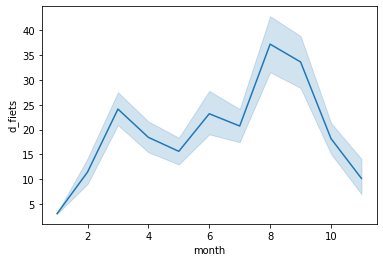

In [324]:
lp = sns.lineplot('month', 'd_fiets', data=df)



Looks like we have a pretty consistent dataset and there are no months missing.

To kick off this descriptive analysis, let us get the full package of plots so information is too small to read for my wannabe data scientist glasses and I can print a wall picture / shower curtain from it.

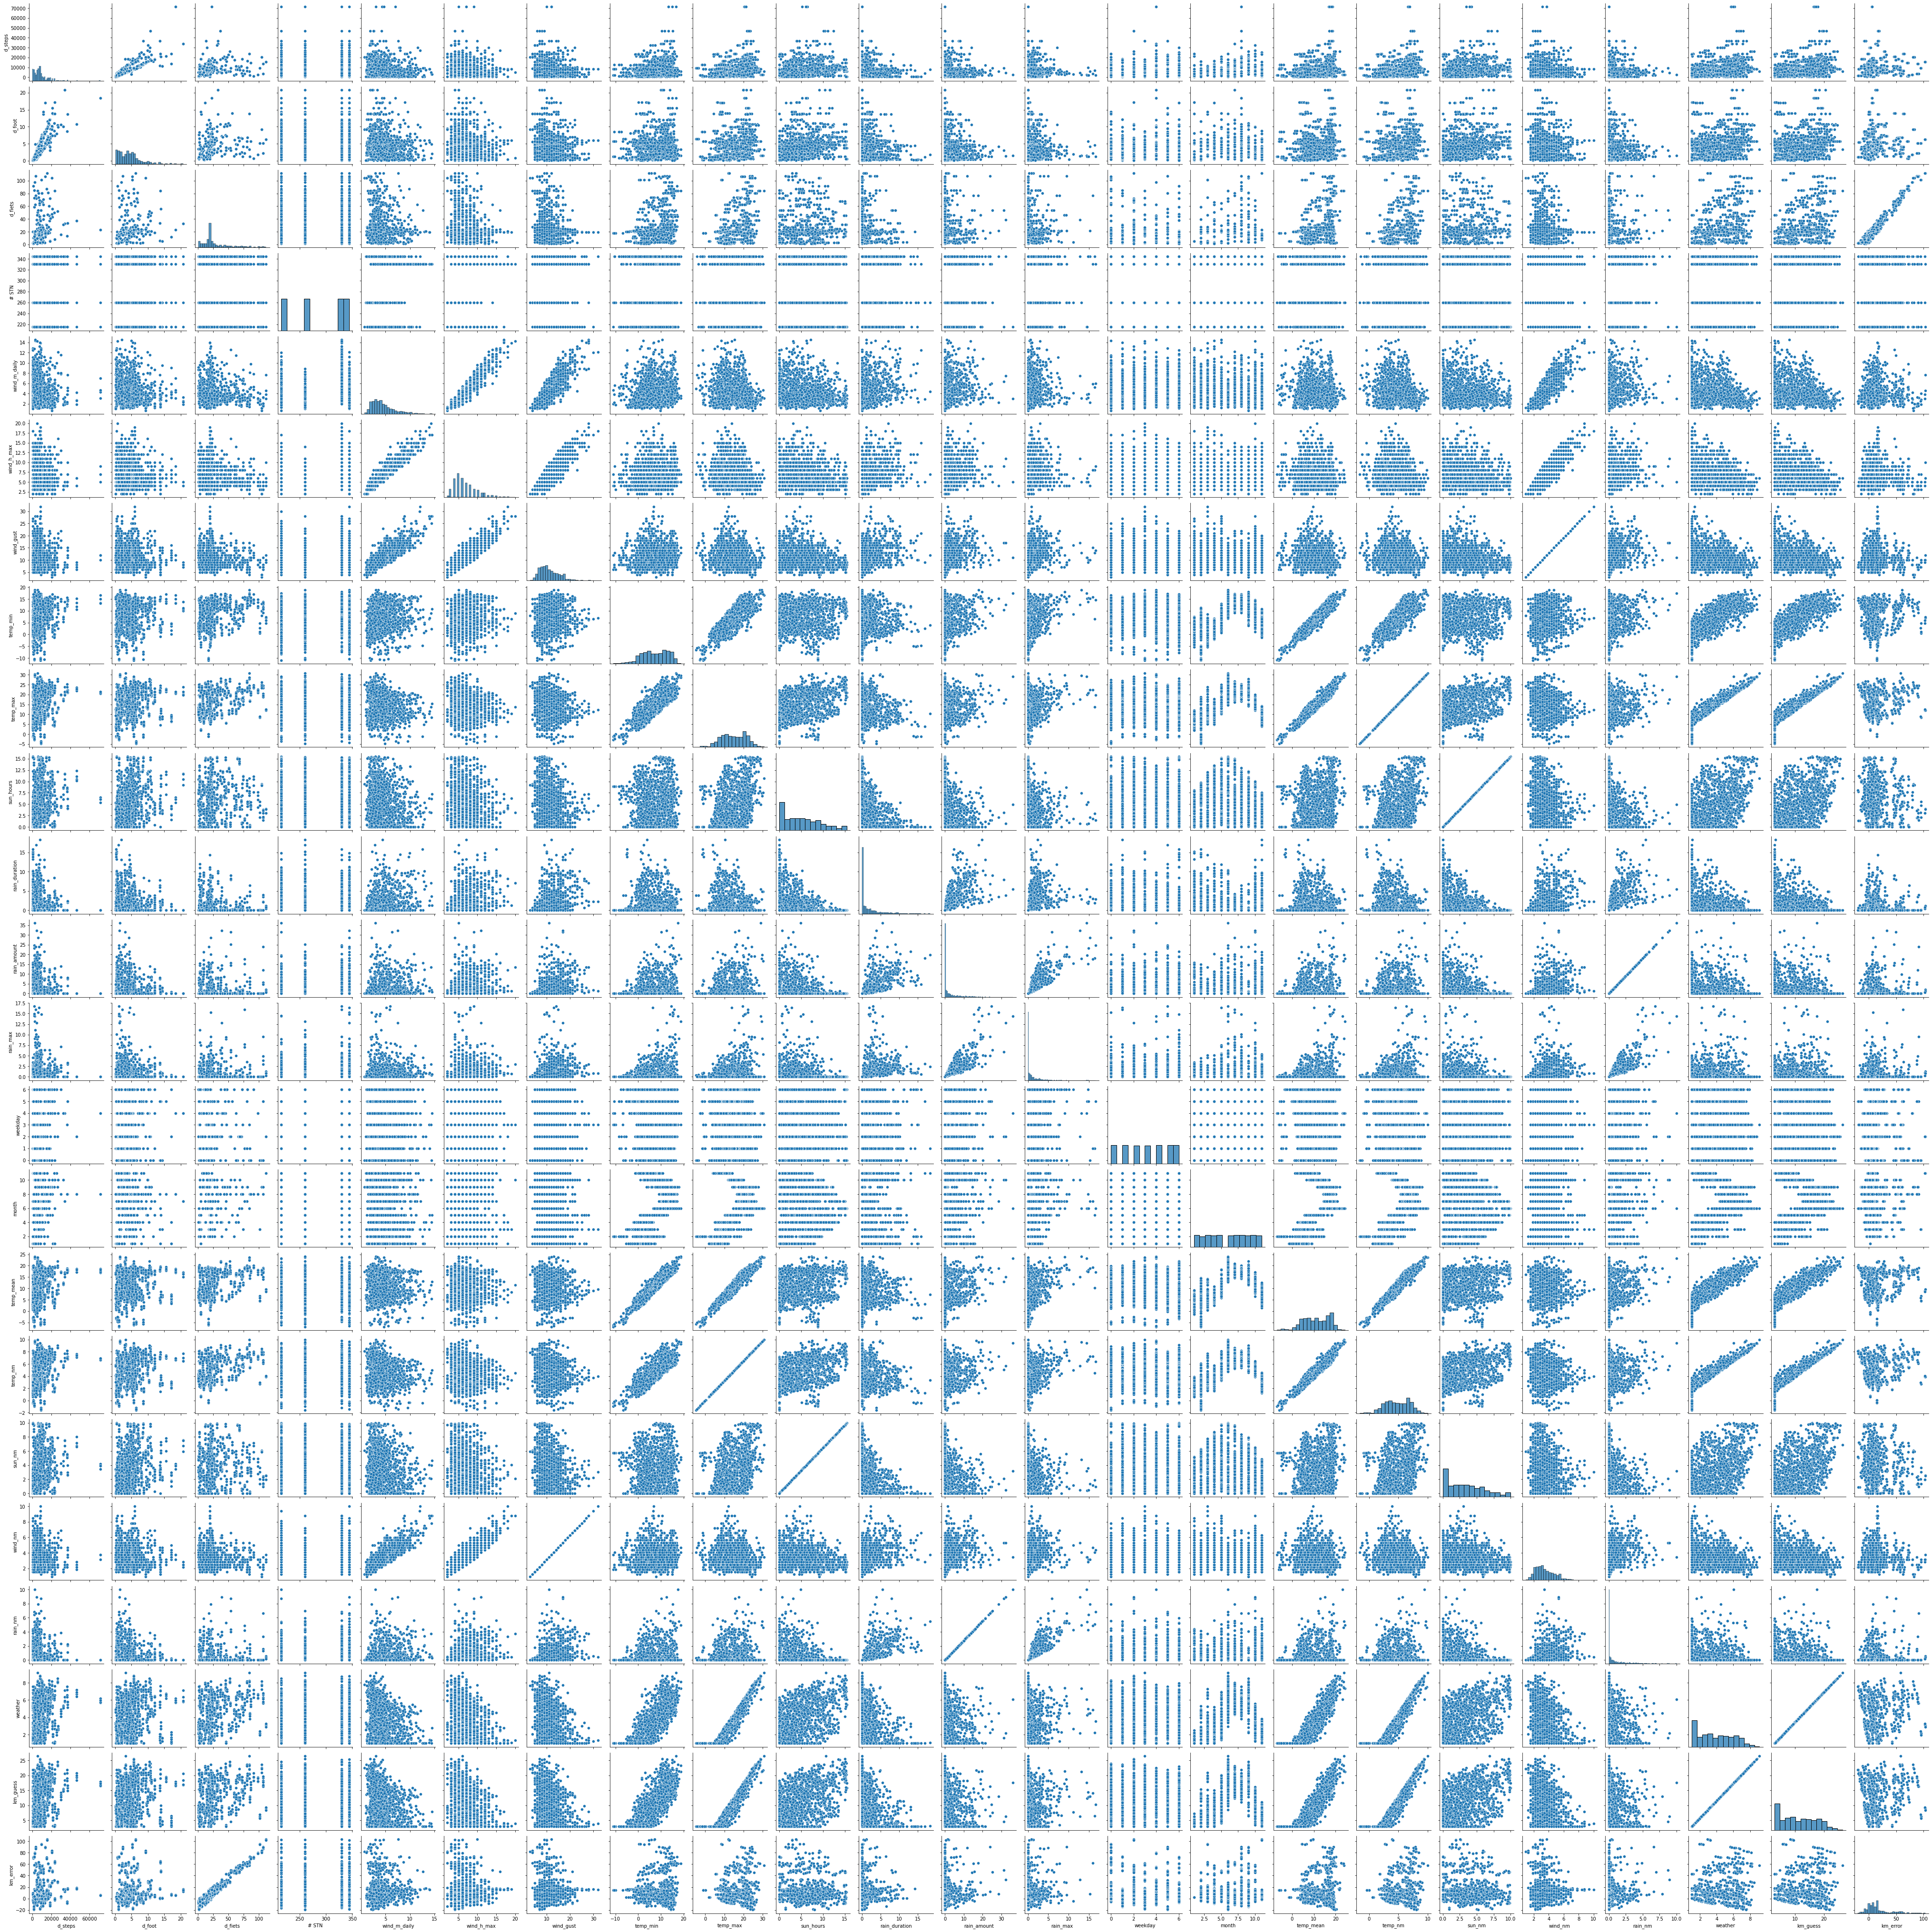

In [255]:
df_num = df.select_dtypes(exclude = ['object', 'bool'])
# sns.pairplot(df_num)
sns.pairplot(df)
plt.show() #using Matplotlib to show the plot



Jokes aside, let us retrieve the right amount of information:


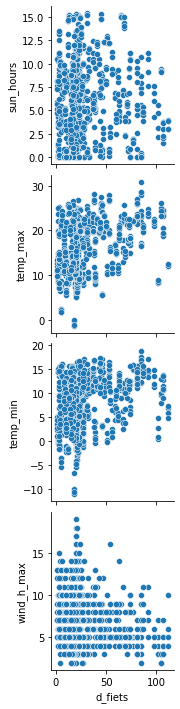

In [256]:

sns.pairplot(data=df, x_vars=['d_fiets'], y_vars=['sun_hours', 'temp_max', 'temp_min', 'wind_h_max'])

What we wanted to proof is a correlation between good weather and cycling distance. While this does not look like a strong positive correlation, since there were certainly sunny days where I either did not track my ride or only made a short distance
- a moderate positive correlation can be seen for temp_max and temp_min
- a moderate negative correlation can be seen for wind_h_max

In [257]:
df.describe

<bound method NDFrame.describe of           @date  d_steps     d_foot  d_fiets  # STN  wind_m_daily  wind_h_max  \
0    2021-01-01    706.0   0.416700      NaN    215           2.1         3.0   
1    2021-01-01    706.0   0.416700      NaN    260           2.1         3.0   
2    2021-01-01    706.0   0.416700      NaN    330           4.8         7.0   
3    2021-01-01    706.0   0.416700      NaN    344           2.5         4.0   
4    2021-01-02  21434.0  13.828057      NaN    215           1.3         3.0   
...         ...      ...        ...      ...    ...           ...         ...   
1331 2021-11-29  12676.0   3.656997      NaN    344           4.3         7.0   
1332 2021-11-30   7968.0   1.825841      NaN    215           7.9        10.0   
1333 2021-11-30   7968.0   1.825841      NaN    260           4.4         7.0   
1334 2021-11-30   7968.0   1.825841      NaN    330          11.7        15.0   
1335 2021-11-30   7968.0   1.825841      NaN    344           7.5        10

d_steps        d_foot       d_fiets         # STN  \
d_steps        1.000000e+00  8.137292e-01  1.081548e-01 -1.782805e-15   
d_foot         8.137292e-01  1.000000e+00  7.643759e-02 -1.756335e-16   
d_fiets        1.081548e-01  7.643759e-02  1.000000e+00 -6.136102e-16   
# STN         -1.782805e-15 -1.756335e-16 -6.136102e-16  1.000000e+00   
wind_m_daily  -1.137881e-01 -1.232254e-01 -1.315083e-01  2.423566e-01   
wind_h_max    -1.173216e-01 -1.168829e-01 -1.608182e-01  2.283392e-01   
wind_gust     -1.307132e-01 -1.312125e-01 -1.753904e-01  1.141945e-01   
temp_min       2.522610e-01  1.368770e-01  2.745029e-01  8.980509e-02   
temp_max       3.052138e-01  2.143145e-01  3.086061e-01  6.777775e-03   
sun_hours      2.167561e-01  2.670458e-01  1.142841e-02  2.606249e-03   
rain_duration -1.762057e-01 -1.763421e-01 -1.411798e-01  8.309789e-03   
rain_amount   -1.163500e-01 -1.496215e-01 -4.680636e-02  1.487729e-02   
rain_max      -9.290295e-02 -1.155120e-01 -1.516793e-02  1.588515e-02   
weekday        4.897514e-02  2.102149e-02 -6.208850e-02  1.375023e-17   
month          2.855328e-01  2.700942e-02  1.608242e-01 -5.172687e-15   
temp_mean      2.912621e-01  1.850445e-01  3.066077e-01  4.720117e-02   
temp_nm        3.052138e-01  2.143145e-01  3.086061e-01  6.777775e-03   
sun_nm         2.167561e-01  2.670458e-01  1.142841e-02  2.606249e-03   
wind_nm       -1.307132e-01 -1.312125e-01 -1.753904e-01  1.141945e-01   
rain_nm       -1.163500e-01 -1.496215e-01 -4.680636e-02  1.487729e-02   
weather        3.239693e-01  2.395955e-01  3.210898e-01 -1.269143e-02   
km_guess       3.239693e-01  2.395955e-01  3.210898e-01 -1.269143e-02   
km_error       3.549104e-02  3.533151e-02  9.705264e-01  3.920393e-03   

               wind_m_daily  wind_h_max  wind_gust  temp_min  temp_max  \
d_steps           -0.113788   -0.117322  -0.130713  0.252261  0.305214   
d_foot            -0.123225   -0.116883  -0.131212  0.136877  0.214314   
d_fiets           -0.131508   -0.160818  -0.175390  0.274503  0.308606   
# STN              0.242357    0.228339   0.114194  0.089805  0.006778   
wind_m_daily       1.000000    0.945505   0.856717  0.042711 -0.219385   
wind_h_max         0.945505    1.000000   0.901491  0.016733 -0.205038   
wind_gust          0.856717    0.901491   1.000000 -0.004066 -0.199369   
temp_min           0.042711    0.016733  -0.004066  1.000000  0.854798   
temp_max          -0.219385   -0.205038  -0.199369  0.854798  1.000000   
sun_hours         -0.175667   -0.147813  -0.217111  0.094603  0.415031   
rain_duration      0.282176    0.318001   0.400234 -0.113151 -0.265496   
rain_amount        0.209638    0.260123   0.365440  0.106427 -0.007189   
rain_max           0.116902    0.160578   0.264155  0.182806  0.094019   
weekday           -0.031058   -0.004727  -0.021797 -0.017106 -0.018443   
month             -0.109573   -0.114675  -0.112346  0.543299  0.489975   
temp_mean         -0.100981   -0.105592  -0.112511  0.957706  0.967975   
temp_nm           -0.219385   -0.205038  -0.199369  0.854798  1.000000   
sun_nm            -0.175667   -0.147813  -0.217111  0.094603  0.415031   
wind_nm            0.856717    0.901491   1.000000 -0.004066 -0.199369   
rain_nm            0.209638    0.260123   0.365440  0.106427 -0.007189   
weather           -0.360581   -0.364110  -0.391149  0.765409  0.953955   
km_guess          -0.360581   -0.364110  -0.391149  0.765409  0.953955   
km_error          -0.042648   -0.069670  -0.079620  0.103886  0.079450   

               sun_hours  ...       weekday         month  temp_mean  \
d_steps         0.216756  ...  4.897514e-02  2.855328e-01   0.291262   
d_foot          0.267046  ...  2.102149e-02  2.700942e-02   0.185044   
d_fiets         0.011428  ... -6.208850e-02  1.608242e-01   0.306608   
# STN           0.002606  ...  1.375023e-17 -5.172687e-15   0.047201   
wind_m_daily   -0.175667  ... -3.105823e-02 -1.095732e-01  -0.100981   
wind_h_max     -0.147813  ... -4.726643e-03 -1.146748e-01 

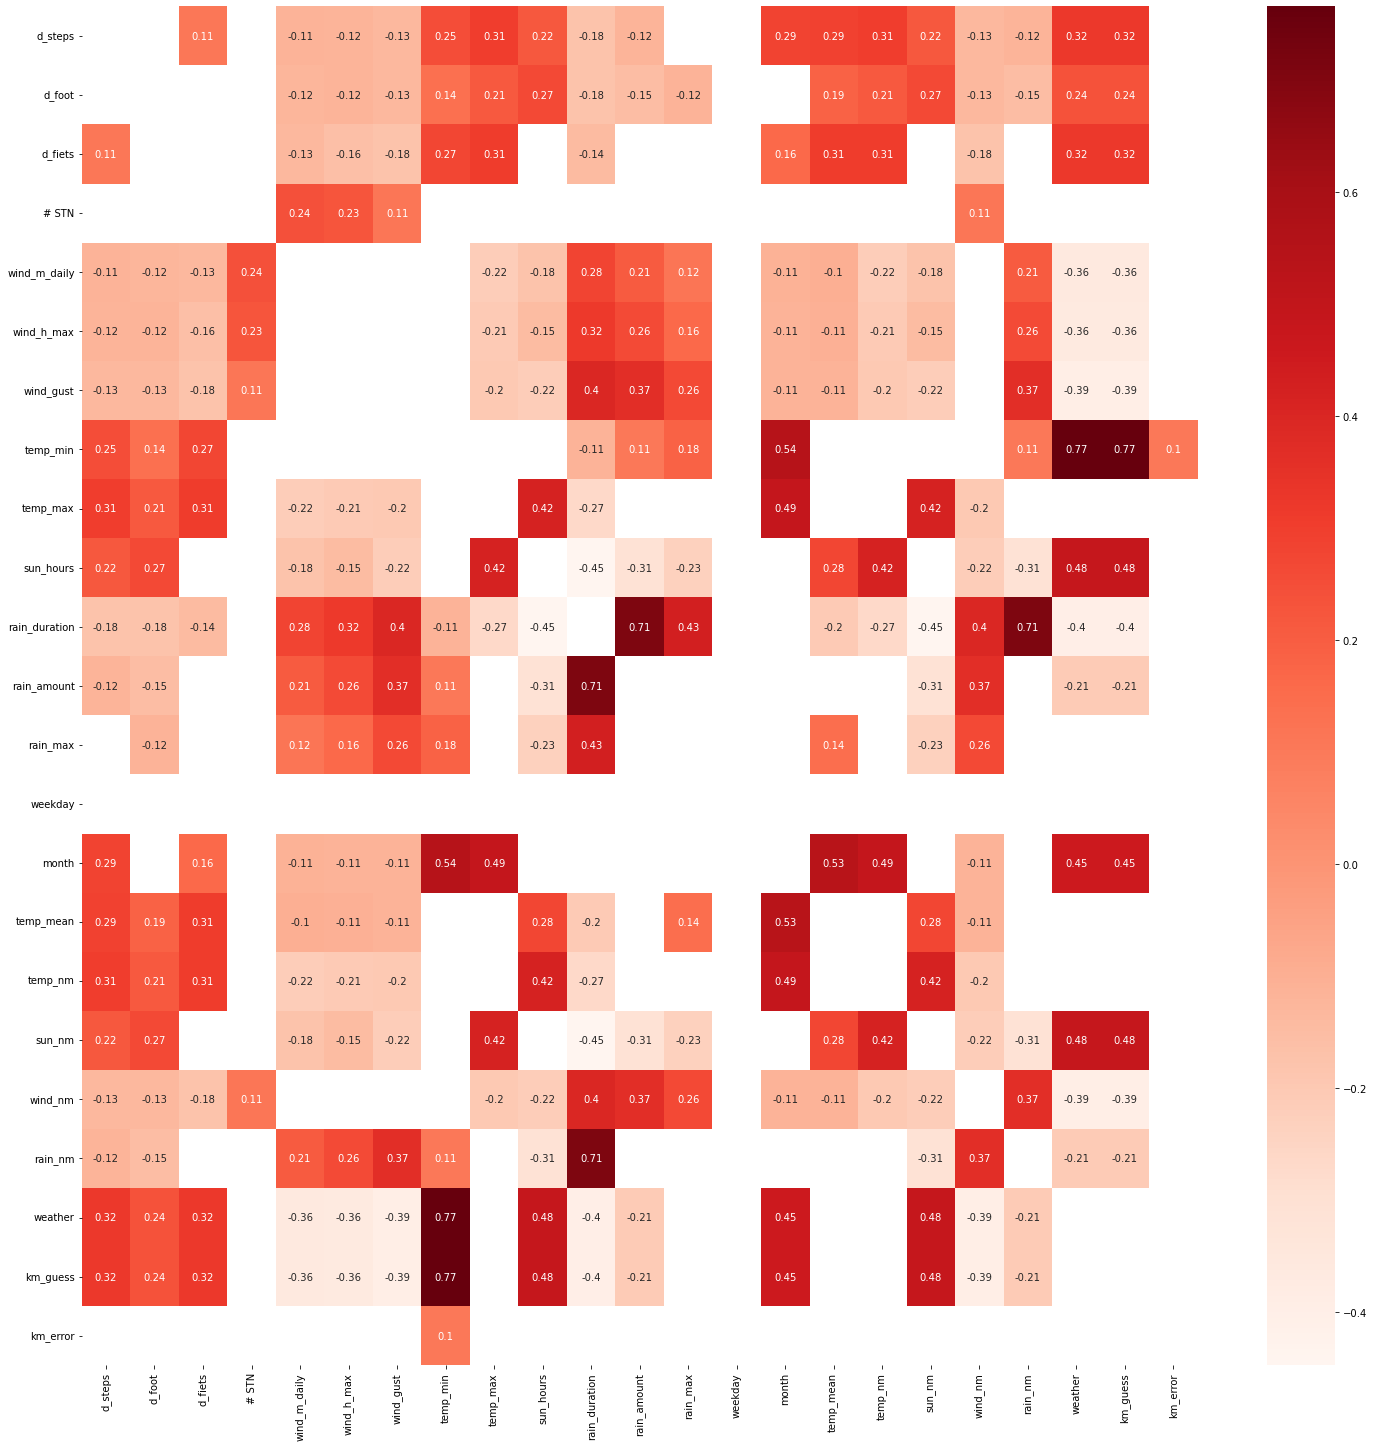

None

In [258]:
def corrFilter(x: pd.DataFrame, bound: float, tbound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) & (xCorr <= tbound)| (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values(ascending=False).drop_duplicates()
    return xFlattened

corr = df.corr()
filtered_corr = corr[(corr >= .1) & (corr <= .8)  | (corr <= -.1) & (corr != 1.00 )]
plt.figure(figsize=(25,25))
sns.heatmap(filtered_corr, cmap="Reds",annot=True)
display(corr)
display(plt.show())


Let us assess the top correlations 

In [259]:
df_corr = pd.Series(corrFilter(df, .1, .9))
df_corr

weather        temp_mean        0.899203
km_guess       temp_mean        0.899203
rain_amount    rain_max         0.869562
rain_nm        rain_max         0.869562
wind_gust      wind_m_daily     0.856717
                                  ...   
weather        rain_duration   -0.397982
rain_duration  km_guess        -0.397982
sun_hours      rain_duration   -0.447193
sun_nm         rain_duration   -0.447193
d_steps        d_steps               NaN
Length: 148, dtype: float64

In [260]:
# df_corr_cl = df_corr_cl.filter(like = '_fiets', axis = 0)


Most correlations seem obvious (much wind over the day correlates with many wind gusts, so does intense rain moments with overall high rain amounts, high temparatures with long sun hours)

Let us find out more about the cycling-related correlations

In [261]:
df_corr_cl = pd.Series(corrFilter(df, .01, .9))

df_corr_cl.dtypes 
df_corr_cl = df_corr_cl.filter(like = '_fiets', axis = 0)

df_corr_cl = df_corr_cl.reset_index()
df_corr_cl


level_0       level_1         0
0         d_fiets      km_guess  0.321090
1         d_fiets       weather  0.321090
2         d_fiets       temp_nm  0.308606
3        temp_max       d_fiets  0.308606
4         d_fiets     temp_mean  0.306608
5         d_fiets      temp_min  0.274503
6           month       d_fiets  0.160824
7         d_fiets       d_steps  0.108155
8          d_foot       d_fiets  0.076438
9       sun_hours       d_fiets  0.011428
10         sun_nm       d_fiets  0.011428
11       rain_max       d_fiets -0.015168
12    rain_amount       d_fiets -0.046806
13        d_fiets       rain_nm -0.046806
14        d_fiets       weekday -0.062088
15        d_fiets  wind_m_daily -0.131508
16  rain_duration       d_fiets -0.141180
17     wind_h_max       d_fiets -0.160818
18        d_fiets       wind_nm -0.175390
19      wind_gust       d_fiets -0.175390

Is this a first relieve? My cycling behaviour appears to be less dependent on the amount of rain, but rather the rain_duration.  
The low dependance on sun_hours also speaks for sort of "season independency" 

Let us have a closer look on the best correlations with a regression line in place, since the box plots gave a good initial overview, yet the density of dots tends to distort our perception.

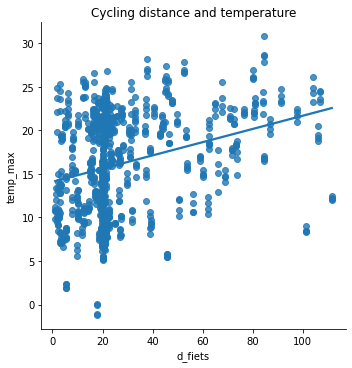

In [262]:
sns.lmplot(x='d_fiets', y='temp_max', data=df, ci=False) 
plt.title('Cycling distance and temperature')
plt.show()

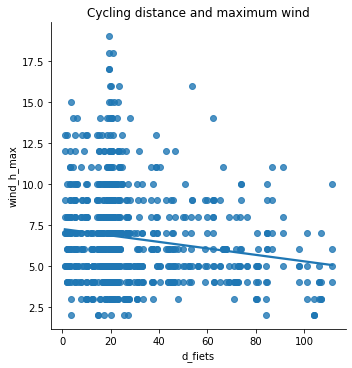

In [263]:
sns.lmplot(x='d_fiets', y='wind_h_max', data=df, ci=False) 
plt.title('Cycling distance and maximum wind')
plt.show()

A clear negative relation, yet a high variation due to many outliers. Would I survive the Tegenwindfietsen 2022? 
As we speak I am wondering anyway, how meaningful the variable of maximum wind speed is, since tail wind can be pretty beneficial in cycling when considered in route planning.

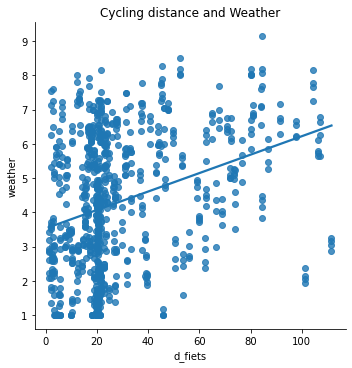

In [264]:
sns.lmplot(x='d_fiets', y='weather', data=df, ci=False) 
plt.title('Cycling distance and Weather')
plt.show()

## Predictive model 🔮

explain which analysis you have chosen and why. In which you build a relevant statistical model or train a machine learning algorithm.

> Dear predictive model, how many kilometres am I going to make tomorrow?

In [265]:

#libraries for building and evaluating my model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer


Since there were missing Strava records on days where I did cycle yet did not start the app for a few kilometers, I wanted to fill those missing records with realistic values. 

 I assume 2km per day (e.g. supermarket ride)

In [266]:
imputer = SimpleImputer(strategy='constant',fill_value= 2, missing_values=np.nan)
imputer = imputer.fit(df[['d_fiets']])
df['d_fiets'] = imputer.transform(df[['d_fiets']])


### Prepare model data

In [295]:

X = df[['temp_max','temp_min','rain_duration', 'wind_gust', 'wind_h_max']] 
# X = df[['temp_max','temp_min', 'rain_duration']] 
y = df['d_fiets']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Testing multiple algorithms

Best suited algorithms for my project

- Random Forest ✅ 
 
- K-nearest neighbor ❌  (Suited for for classification)
- K-means ❌  (For clustering)

#### Random Forest 🌲🎄
First contestent is the Random Forest algorithm, which I chose since it works well with both numerical and categorical data and its known resiliance to outliers 


In [296]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 21)
rf.fit(X_train, y_train);

https://medium.com/analytics-vidhya/testing-multiple-machine-learning-models-at-once-without-getting-a-headache-5aefb0e7df03


In [303]:
y_test_p = rf.predict(X_test)

y_test_p

errors = abs(y_test_p - y_test)
mean_absolute_error = round(np.mean(errors)) #calculating mean absolute error
improvement = baseline_error - mean_absolute_error #

# improvement=improvement.reshape(790,1)


print('Mean Absolute Error:', round(np.mean(errors)))
print('The deviation between the mean absolute error of the model and the baseline is:', improvement, " km")

Mean Absolute Error: 14
The deviation between the mean absolute error of the model and the baseline is: 2.434829443003945  km


## Evaluation 🧐
evaluate the model: numerically, qualitatively and in terms of practical value.


In [321]:
r2 = r2_score(y_test, y_test_p)
print('R2 is', round(r2, 2), ".", round((r2*100)), "% variation can be explained by the model")

R2 is 0.03 . 3 % variation can be explained by the model


0̶.̶1̶9̶ ̶d̶o̶e̶s̶ ̶n̶o̶t̶ ̶s̶e̶e̶m̶ ̶l̶i̶k̶e̶ ̶a̶ ̶r̶e̶a̶l̶l̶y̶ ̶g̶o̶o̶d̶ ̶v̶a̶l̶u̶e̶ ̶a̶t̶ ̶f̶i̶r̶s̶t̶ ̶g̶l̶a̶n̶c̶e̶.̶ ̶

0.03 does not seem like a really good value at first glance. 

For some reason the value was fluctuating quite a bit within the last testing phase and is now surprisingly low. 

I will troubleshoot further and might know more after the deadline 🤷🏽‍♂️



On the other hand: Did I want to be predictable? 
Overall it carries a good message for me: If I would not have gone outside cycling in the code yellow storm or cycled 60km to Utrecht at around 10 degrees, the correlation would be more significant and I could be considered a "good weather cyclist" - the very stigma I aimed to prove wrong

https://dutchreview.com/featured/the-dutchest-thing-ever-cycling-in-the-rain/

In an age, where algorithmns dominate and predict our digital lives, it might it might be exactly what excites me about cycling. The manual, autonomous aspect: being able to move freely without having to leave digital traces behind you, being able to decide where to turn. A breakaway from the digital world, whose stories experienced on the road are unpredictable. 

Let us explore the predicted vs. actual values on a graph

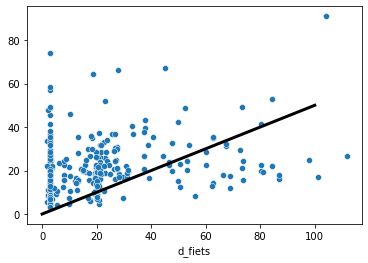

In [300]:
sns.scatterplot(x=y_test,y=y_test_p)
plt.plot([0, 100], [0, 50], color='black', lw=3) 

plt.show()

The results seem farther off than initially exptected. Especially the difference between my prediction and the random forest prediction. 
Let's bring in another algorithm.



This could be an interesting foundation for a project that feeds users with cycling-related information based on the current weather. E.g. predicting cycling performance and recommend clothing based on the current conditions. 
- A weather-based cycling assistant that gives cyclists the best route based on the weather might also conceivable.  
- An application that provides users with personalized content, including motivational messages depending on the given situation. 
- A "beat your beat" feature in the Strava app suggesting a daily kilometer target based on the given condition to keep up with a certain streak


This project not only helped me in sparking new ideas, yet also taught me a lesson on my biases: It appears that the amount of wind, rain and temparature indeed has an influence on my cycling behaviour, yet smaller influence than found in named other studies. This might materialise as a mission for me to sell the Dutch way of cycling globally through promoting proper gear or other cycling hacks for people who are new to the scene.  



# References

<div class="csl-entry">Thomas, T., Jaarsma, R., &#38; Tutert, B. (2013). Exploring temporal fluctuations of daily cycling demand on Dutch cycle paths: The influence of weather on cycling. <i>Transportation</i>, <i>40</i>(1), 1–22. https://doi.org/10.1007/s11116-012-9398-5</div>
<div class="csl-entry">Pazdan, S., Kiec, M., &#38; D’Agostino, C. (2021). Impact of environment on bicycle travel demand—Assessment using bikeshare system data. <i>Sustainable Cities and Society</i>, <i>67</i>. https://doi.org/10.1016/j.scs.2021.102724</div>
<div class="csl-entry">Wen, X., Ma, Y., Yuan, B., &#38; Wang, F. (2019). Association among Weather Conditions, Ambient Air Temperature, and Sedentary Time in Chinese Adults. <i>BioMed Research International</i>, <i>2019</i>. https://doi.org/10.1155/2019/4010898</div>